### Test of generating alternating single qubit and two qubit layers

In [2]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from utils.layers import alternating_sq_2q_layers

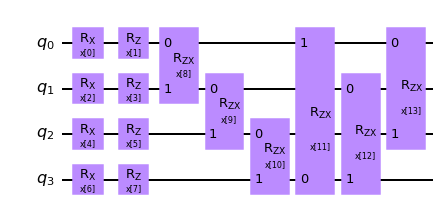

In [54]:
connectivity = [[0,1], [1,2], [2,3],[3,0], [1,3], [0,2]]
circ = alternating_sq_2q_layers(4,1,'RZX', connectivity)
circ.draw('mpl')
# circ.draw('mpl')

In [4]:
# qasm convert
print(qiskit.qasm2.dumps(circ.assign_parameters(np.ones(14))))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
rx(1.0) q[0];
rz(1.0) q[0];
rx(1.0) q[1];
rz(1.0) q[1];
rx(1.0) q[2];
rz(1.0) q[2];
rx(1.0) q[3];
rz(1.0) q[3];
rxx(1.0) q[0],q[1];
rxx(1.0) q[1],q[2];
rxx(1.0) q[2],q[3];
rxx(1.0) q[3],q[0];
rxx(1.0) q[1],q[3];
rxx(1.0) q[0],q[2];


In [56]:
from qiskit_algorithms.optimizers import L_BFGS_B, COBYLA
from qiskit_aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi

intermediate_cost = []
intermediate_params = []

def cost(params, target):
    '''
    target: dict
            count_dictionary obtained from the probe circuit
    params: 
    '''
    connectivity = [[0,1], [1,2], [2,3],[3,0], [1,3], [0,2]]
    circ = alternating_sq_2q_layers(4,1,'RXX', connectivity, measurement=False).assign_parameters(params)
    result_dict = qi.Statevector.from_instruction(circ).probabilities_dict()
    cost = 0
    for (key1, value1), (key2, value2) in zip(target.items(), result_dict.items()):
        cost += (value1-value2)**2 
    
    intermediate_cost.append(cost)
    intermediate_params.append(params)
    return cost

def callback_func(params, target):
    cost_value = cost(params, target)  # Calculate the cost at the current iteration
    intermediate_cost.append(cost_value)
    intermediate_params.append(params)

In [57]:
import torch
import torch.optim as optim
import qiskit.quantum_info as qi

params = np.ones(14)
circ = alternating_sq_2q_layers(4,1,'RXX', connectivity, measurement=False).assign_parameters(params)
target = qi.Statevector.from_instruction(circ).probabilities_dict()
target

{'0000': 0.12617565065018493,
 '0001': 0.005809569833027938,
 '0010': 0.0058095698330279345,
 '0011': 0.021492938817427427,
 '0100': 0.005809569833027941,
 '0101': 0.021492938817427427,
 '0110': 0.02149293881742741,
 '0111': 0.10853778902716256,
 '1000': 0.005809569833027945,
 '1001': 0.021492938817427427,
 '1010': 0.021492938817427445,
 '1011': 0.10853778902716252,
 '1100': 0.021492938817427445,
 '1101': 0.10853778902716256,
 '1110': 0.10853778902716252,
 '1111': 0.2874772810044898}

In [58]:
from scipy.optimize import minimize
parameters = [np.random.random() for _ in range(14)]
out = minimize(cost, x0=parameters, args = target ,method="L-BFGS-B", options={'maxiter':100})
cost(out.jac,target)

0.896240670072787

In [59]:
out.jac

array([-1.41546651e-06, -1.78174965e-06,  1.05303292e-06, -8.84533349e-06,
       -5.14884992e-06, -4.96902815e-06,  1.57111053e-06, -1.70004763e-07,
        1.20040665e-06, -1.43475355e-06, -4.68359519e-06, -2.80636315e-06,
       -4.76958325e-06,  3.84609827e-06])

In [60]:
cost(intermediate_params[np.argmin(intermediate_cost)],target)

5.159995737573821e-07

In [61]:
check = alternating_sq_2q_layers(4,1,'RXX', connectivity, measurement=False).assign_parameters(intermediate_params[np.argmin(intermediate_cost)])
check_result = qi.Statevector.from_instruction(check).probabilities_dict()
check_result

{'0000': 0.12635994386531418,
 '0001': 0.005929914043627379,
 '0010': 0.0057578524646348635,
 '0011': 0.0214136207065688,
 '0100': 0.005829182020298167,
 '0101': 0.021149335928561414,
 '0110': 0.021551645412526944,
 '0111': 0.10870723336959039,
 '1000': 0.005829579019813608,
 '1001': 0.02143430912479111,
 '1010': 0.02172792844147182,
 '1011': 0.10855764183143093,
 '1100': 0.021563892945053707,
 '1101': 0.10868848570074209,
 '1110': 0.10848954930978753,
 '1111': 0.28700988581578674}

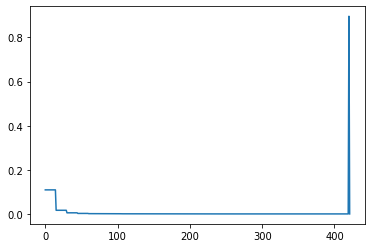

In [62]:
import matplotlib.pyplot as plt
plt.plot(intermediate_cost)